# **主要改變的地方為建立VAE模型的dense層**

## 讀取套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

from tensorflow.keras import losses

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 讀取mnist資料集，並進行前處理

In [3]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()


X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)


X_train = X_train / X_train.max()
X_test = X_test / X_test.max()


y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

## **VAE建立**
相較於助教的tutorial
我增加維度為64,128,256,512的encoding跟decoding layer。
並且參考其他同學的操弄，將部分的layer的activation function改成relu。

In [4]:
enc_1 = Dense(512, activation='relu')
enc_2 = Dense(256, activation='relu')
enc_3 = Dense(128, activation='relu')
enc_4 = Dense(64, activation='sigmoid')

enc_mean = Dense(2)#為了後續繪製2維圖而設定
enc_log_var = Dense(2)

dec_5=Dense(64,activation='relu')
dec_4 = Dense(128, activation='relu')
dec_3 = Dense(256, activation='relu')
dec_2 = Dense(512, activation='relu')
dec_1 = Dense(784, activation='sigmoid')

In [5]:
x = Input(shape=(784,))
enc_x =enc_4(enc_3(enc_2(enc_1(x))))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

### 自訂抽樣函數

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### 將自訂的抽樣函數透過lambda轉換成Keras layer

In [7]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

### 定義decoder

In [8]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(dec_4(dec_5(z_input)))))

### 組合模型並檢視模型結構

In [9]:
x_hat = dec_1(dec_2(dec_3(dec_4(dec_5(z)))))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
______________________________________________________________________________________________

### 定義VAE的loss函數

In [10]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

### 訓練模型

In [11]:
VAE.compile(optimizer=Adam())


In [15]:
VAE.fit(X_train, batch_size=512,epochs=10,)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 137us/sample - loss: 44.5678
Epoch 2/10
60000/60000 [==============================] - 9s 148us/sample - loss: 43.4644
Epoch 3/10
60000/60000 [==============================] - 9s 142us/sample - loss: 42.6065
Epoch 4/10
60000/60000 [==============================] - 11s 178us/sample - loss: 42.0055
Epoch 5/10
60000/60000 [==============================] - 8s 130us/sample - loss: 41.6711
Epoch 6/10
60000/60000 [==============================] - 9s 145us/sample - loss: 41.3301
Epoch 7/10
60000/60000 [==============================] - 8s 139us/sample - loss: 41.0437
Epoch 8/10
60000/60000 [==============================] - 8s 128us/sample - loss: 40.6623
Epoch 9/10
60000/60000 [==============================] - 7s 125us/sample - loss: 40.3822
Epoch 10/10
60000/60000 [==============================] - 8s 136us/sample - loss: 40.2466


### 保存模型參數

In [16]:
VAE.save_weights('VAE_model_weights.h5')

### VAE 視覺化呈現

In [17]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 574,530
Trainable params: 574,530
Non-trainable params: 0
_____________________________________________________

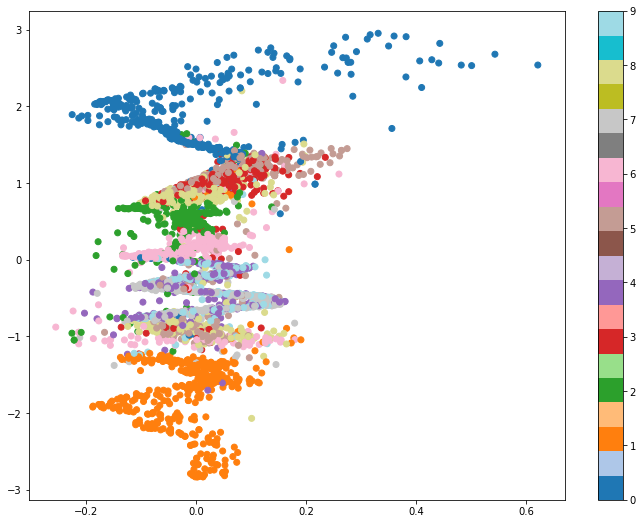

In [18]:
indices = np.random.randint(X_train.shape[0], size=4000) #選2500個資料點呈現

VAE_latents = VAE_Encoder.predict(X_train[indices])
plt.figure(figsize=(12, 9))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

### Decoder 視覺化呈現

In [19]:
VAE_Decoder =  Model(z_input, dec_1(dec_2(dec_3(dec_4(dec_5(z_input))))))

VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 784)               402192    
Total params: 575,312
Trainable params: 575,312
Non-trainable params: 0
_____________________________________________________

In [20]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [21]:
n=15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

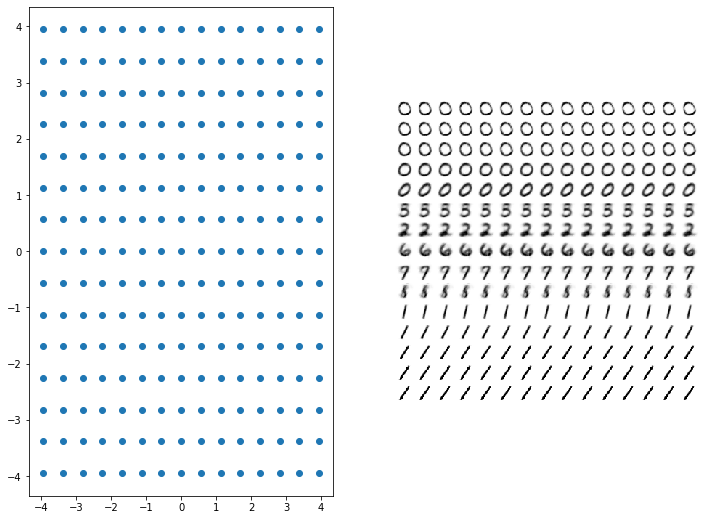

In [22]:
plt.figure(figsize=(12, 9))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()


## 動態比較

In [23]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')
from ipywidgets import interact, IntSlider, FloatSlider
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>

## 結果呈現

In [40]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://i.imgur.com/7vxMHmw.jpg")

In [41]:
Image(url= "https://i.imgur.com/gDUuQ9Z.jpg")

In [42]:
Image(url= "https://i.imgur.com/FgUKFl8.jpg")

In [44]:
Image(url= "https://i.imgur.com/doLwLiv.jpg")